In [1]:
import torch
torch.cuda.set_device(0)
import torch.nn as nn
from thop import profile
import os
from pathlib import Path
import pandas as pd
##---------- Basic Layers ----------
def conv3x3(in_chn, out_chn, bias=True):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1, bias=bias)
    return layer


def conv(in_channels, out_channels, kernel_size, bias=False, stride=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size,
        padding=(kernel_size // 2),
        bias=bias,
        stride=stride,
    )


def bili_resize(factor):
    return nn.Upsample(scale_factor=factor, mode="bilinear", align_corners=False)


##---------- Basic Blocks ----------
class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample):
        super(UNetConvBlock, self).__init__()
        self.downsample = downsample
        self.block = SK_RDB(in_channels=in_size, growth_rate=out_size, num_layers=3)
        if downsample:
            self.downsample = PS_down(out_size, out_size, downscale=2)

    def forward(self, x):
        out = self.block(x)
        if self.downsample:
            out_down = self.downsample(out)
            return out_down, out
        else:
            return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUpBlock, self).__init__()
        # self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, bias=True)
        self.up = PS_up(in_size, out_size, upscale=2)
        self.conv_block = UNetConvBlock(in_size, out_size, False)

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], dim=1)
        out = self.conv_block(out)
        return out


##---------- Resizing Modules (Pixel(Un)Shuffle) ----------
class PS_down(nn.Module):
    def __init__(self, in_size, out_size, downscale):
        super(PS_down, self).__init__()
        self.UnPS = nn.PixelUnshuffle(downscale)
        self.conv1 = nn.Conv2d((downscale**2) * in_size, out_size, 1, 1, 0)

    def forward(self, x):
        x = self.UnPS(x)  # h/2, w/2, 4*c
        x = self.conv1(x)
        return x


class PS_up(nn.Module):
    def __init__(self, in_size, out_size, upscale):
        super(PS_up, self).__init__()

        self.PS = nn.PixelShuffle(upscale)
        self.conv1 = nn.Conv2d(in_size // (upscale**2), out_size, 1, 1, 0)

    def forward(self, x):
        x = self.PS(x)  # h/2, w/2, 4*c
        x = self.conv1(x)
        return x


##---------- Selective Kernel Feature Fusion (SKFF) ----------
class SKFF(nn.Module):
    def __init__(self, in_channels, height=3, reduction=8, bias=False):
        super(SKFF, self).__init__()

        self.height = height
        d = max(int(in_channels / reduction), 4)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(in_channels, d, 1, padding=0, bias=bias), nn.PReLU()
        )

        self.fcs = nn.ModuleList([])
        for i in range(self.height):
            self.fcs.append(
                nn.Conv2d(d, in_channels, kernel_size=1, stride=1, bias=bias)
            )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, inp_feats):
        batch_size, n_feats, H, W = inp_feats[1].shape

        inp_feats = torch.cat(inp_feats, dim=1)
        inp_feats = inp_feats.view(
            batch_size, self.height, n_feats, inp_feats.shape[2], inp_feats.shape[3]
        )

        feats_U = torch.sum(inp_feats, dim=1)
        feats_S = self.avg_pool(feats_U)
        feats_Z = self.conv_du(feats_S)

        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        attention_vectors = torch.cat(attention_vectors, dim=1)
        attention_vectors = attention_vectors.view(
            batch_size, self.height, n_feats, 1, 1
        )

        attention_vectors = self.softmax(attention_vectors)
        feats_V = torch.sum(inp_feats * attention_vectors, dim=1)

        return feats_V


##---------- Dense Block ----------
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, I):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)
        self.sk = SKFF(out_channels, height=2, reduction=8, bias=False)

    def forward(self, x):
        x1 = self.relu(self.conv(x))
        # output = torch.cat([x, x1], 1) # -> RDB
        output = self.sk((x, x1))
        return output


##---------- Selective Kernel Residual Dense Block (SK-RDB) ----------
class SK_RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(SK_RDB, self).__init__()
        self.identity = nn.Conv2d(in_channels, growth_rate, 1, 1, 0)
        self.layers = nn.Sequential(
            *[DenseLayer(in_channels, in_channels, I=i) for i in range(num_layers)]
        )
        self.lff = nn.Conv2d(in_channels, growth_rate, kernel_size=1)

    def forward(self, x):
        res = self.identity(x)
        x = self.layers(x)
        x = self.lff(x)
        return res + x


##---------- testNet ----------
class SRMNet(nn.Module):
    def __init__(self, in_chn=3, wf=96, depth=4):
        super(SRMNet, self).__init__()
        self.depth = depth
        self.down_path = nn.ModuleList()
        self.bili_down = bili_resize(0.5)
        self.conv_01 = nn.Conv2d(in_chn, wf, 3, 1, 1)

        # encoder of UNet
        prev_channels = 0
        for i in range(depth):  # 0,1,2,3
            downsample = True if (i + 1) < depth else False
            self.down_path.append(
                UNetConvBlock(prev_channels + wf, (2**i) * wf, downsample)
            )
            prev_channels = (2**i) * wf

        # decoder of UNet
        self.up_path = nn.ModuleList()
        self.skip_conv = nn.ModuleList()
        self.conv_up = nn.ModuleList()
        self.bottom_conv = nn.Conv2d(prev_channels, wf, 3, 1, 1)
        self.bottom_up = bili_resize(2 ** (depth - 1))

        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, (2**i) * wf))
            self.skip_conv.append(nn.Conv2d((2**i) * wf, (2**i) * wf, 3, 1, 1))
            self.conv_up.append(
                nn.Sequential(
                    *[nn.Conv2d((2**i) * wf, wf, 3, 1, 1), bili_resize(2**i)]
                )
            )
            prev_channels = (2**i) * wf

        self.final_ff = SKFF(in_channels=wf, height=depth)
        self.last = conv3x3(prev_channels, in_chn, bias=True)

    def forward(self, x):
        img = x
        scale_img = img

        ##### shallow conv #####
        x1 = self.conv_01(img)
        encs = []
        ######## UNet ########
        # Down-path (Encoder)
        for i, down in enumerate(self.down_path):
            if i == 0:
                x1, x1_up = down(x1)
                encs.append(x1_up)
            elif (i + 1) < self.depth:
                scale_img = self.bili_down(scale_img)
                left_bar = self.conv_01(scale_img)
                x1 = torch.cat([x1, left_bar], dim=1)
                x1, x1_up = down(x1)
                encs.append(x1_up)
            else:
                scale_img = self.bili_down(scale_img)
                left_bar = self.conv_01(scale_img)
                x1 = torch.cat([x1, left_bar], dim=1)
                x1 = down(x1)

        # Up-path (Decoder)
        ms_result = [self.bottom_up(self.bottom_conv(x1))]
        for i, up in enumerate(self.up_path):
            x1 = up(x1, self.skip_conv[i](encs[-i - 1]))
            ms_result.append(self.conv_up[i](x1))
        # Multi-scale selective feature fusion
        msff_result = self.final_ff(ms_result)

        ##### Reconstruct #####
        out_1 = self.last(msff_result) + img

        return out_1

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.optim import lr_scheduler

# U-Net: Convolutional Networks for Biomedical Image Segmentation
# https://arxiv.org/abs/1505.04597
class UNet(nn.Module):
    def __init__(self, nch_in, nch_out, nch_ker=64, norm="bnorm"):
        super(UNet, self).__init__()

        self.nch_in = nch_in
        self.nch_out = nch_out
        self.nch_ker = nch_ker
        self.norm = norm

        if norm == "bnorm":
            self.bias = False
        else:
            self.bias = True

        """
        Encoder part
        """

        self.enc1_1 = CNR2d(
            1 * self.nch_in,
            1 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.enc1_2 = CNR2d(
            1 * self.nch_ker,
            1 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.pool1 = Pooling2d(pool=2, type="avg")

        self.enc2_1 = CNR2d(
            1 * self.nch_ker,
            2 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.enc2_2 = CNR2d(
            2 * self.nch_ker,
            2 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.pool2 = Pooling2d(pool=2, type="avg")

        self.enc3_1 = CNR2d(
            2 * self.nch_ker,
            4 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.enc3_2 = CNR2d(
            4 * self.nch_ker,
            4 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.pool3 = Pooling2d(pool=2, type="avg")

        self.enc4_1 = CNR2d(
            4 * self.nch_ker,
            8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.enc4_2 = CNR2d(
            8 * self.nch_ker,
            8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.pool4 = Pooling2d(pool=2, type="avg")

        self.enc5_1 = CNR2d(
            8 * self.nch_ker,
            2 * 8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        """
        Decoder part
        """

        self.dec5_1 = DECNR2d(
            2 * 8 * self.nch_ker,
            8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.unpool4 = UnPooling2d(pool=2, type="nearest")

        self.dec4_2 = DECNR2d(
            2 * 8 * self.nch_ker,
            8 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.dec4_1 = DECNR2d(
            8 * self.nch_ker,
            4 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.unpool3 = UnPooling2d(pool=2, type="nearest")

        self.dec3_2 = DECNR2d(
            2 * 4 * self.nch_ker,
            4 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.dec3_1 = DECNR2d(
            4 * self.nch_ker,
            2 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.unpool2 = UnPooling2d(pool=2, type="nearest")

        self.dec2_2 = DECNR2d(
            2 * 2 * self.nch_ker,
            2 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.dec2_1 = DECNR2d(
            2 * self.nch_ker,
            1 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )

        self.unpool1 = UnPooling2d(pool=2, type="nearest")

        self.dec1_2 = DECNR2d(
            2 * 1 * self.nch_ker,
            1 * self.nch_ker,
            kernel_size=3,
            stride=1,
            norm=self.norm,
            relu=0.0,
            drop=[],
        )
        self.dec1_1 = DECNR2d(
            1 * self.nch_ker,
            1 * self.nch_out,
            kernel_size=3,
            stride=1,
            norm=[],
            relu=[],
            drop=[],
            bias=False,
        )

    def forward(self, x):

        """
        Encoder part
        """

        enc1 = self.enc1_2(self.enc1_1(x))
        pool1 = self.pool1(enc1)

        enc2 = self.enc2_2(self.enc2_1(pool1))
        pool2 = self.pool2(enc2)

        enc3 = self.enc3_2(self.enc3_1(pool2))
        pool3 = self.pool3(enc3)

        enc4 = self.enc4_2(self.enc4_1(pool3))
        pool4 = self.pool4(enc4)

        enc5 = self.enc5_1(pool4)

        """
        Encoder part
        """
        dec5 = self.dec5_1(enc5)

        unpool4 = self.unpool4(dec5)
        cat4 = torch.cat([enc4, unpool4], dim=1)
        dec4 = self.dec4_1(self.dec4_2(cat4))

        unpool3 = self.unpool3(dec4)
        cat3 = torch.cat([enc3, unpool3], dim=1)
        dec3 = self.dec3_1(self.dec3_2(cat3))

        unpool2 = self.unpool2(dec3)
        cat2 = torch.cat([enc2, unpool2], dim=1)
        dec2 = self.dec2_1(self.dec2_2(cat2))

        unpool1 = self.unpool1(dec2)
        cat1 = torch.cat([enc1, unpool1], dim=1)
        dec1 = self.dec1_1(self.dec1_2(cat1))

        x = dec1

        return x


class CNR2d(nn.Module):
    def __init__(
        self,
        nch_in,
        nch_out,
        kernel_size=4,
        stride=1,
        padding=1,
        norm="bnorm",
        relu=0.0,
        drop=[],
        bias=[],
    ):
        super().__init__()

        if bias == []:
            if norm == "bnorm":
                bias = False
            else:
                bias = True

        layers = []
        layers += [
            Conv2d(
                nch_in,
                nch_out,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias,
            )
        ]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)


class DECNR2d(nn.Module):
    def __init__(
        self,
        nch_in,
        nch_out,
        kernel_size=4,
        stride=1,
        padding=1,
        output_padding=0,
        norm="bnorm",
        relu=0.0,
        drop=[],
        bias=[],
    ):
        super().__init__()

        if bias == []:
            if norm == "bnorm":
                bias = False
            else:
                bias = True

        layers = []
        layers += [
            Deconv2d(
                nch_in,
                nch_out,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=output_padding,
                bias=bias,
            )
        ]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.decbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.decbr(x)


class ResBlock(nn.Module):
    def __init__(
        self,
        nch_in,
        nch_out,
        kernel_size=3,
        stride=1,
        padding=1,
        padding_mode="reflection",
        norm="bnorm",
        relu=0.0,
        drop=[],
        bias=[],
    ):
        super().__init__()

        if bias == []:
            if norm == "bnorm":
                bias = False
            else:
                bias = True

        layers = []

        # 1st conv
        layers += [Padding(padding, padding_mode=padding_mode)]
        layers += [
            CNR2d(
                nch_in,
                nch_out,
                kernel_size=kernel_size,
                stride=stride,
                padding=0,
                norm=norm,
                relu=relu,
            )
        ]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        # 2nd conv
        layers += [Padding(padding, padding_mode=padding_mode)]
        layers += [
            CNR2d(
                nch_in,
                nch_out,
                kernel_size=kernel_size,
                stride=stride,
                padding=0,
                norm=norm,
                relu=[],
            )
        ]

        self.resblk = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.resblk(x)


class CNR1d(nn.Module):
    def __init__(self, nch_in, nch_out, norm="bnorm", relu=0.0, drop=[]):
        super().__init__()

        if norm == "bnorm":
            bias = False
        else:
            bias = True

        layers = []
        layers += [nn.Linear(nch_in, nch_out, bias=bias)]

        if norm != []:
            layers += [Norm2d(nch_out, norm)]

        if relu != []:
            layers += [ReLU(relu)]

        if drop != []:
            layers += [nn.Dropout2d(drop)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)


class Conv2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(
            nch_in,
            nch_out,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, x):
        return self.conv(x)


class Deconv2d(nn.Module):
    def __init__(
        self,
        nch_in,
        nch_out,
        kernel_size=4,
        stride=1,
        padding=1,
        output_padding=0,
        bias=True,
    ):
        super(Deconv2d, self).__init__()
        self.deconv = nn.ConvTranspose2d(
            nch_in,
            nch_out,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            bias=bias,
        )

        # layers = [nn.Upsample(scale_factor=2, mode='bilinear'),
        #           nn.ReflectionPad2d(1),
        #           nn.Conv2d(nch_in , nch_out, kernel_size=3, stride=1, padding=0)]
        #
        # self.deconv = nn.Sequential(*layers)

    def forward(self, x):
        return self.deconv(x)


class Linear(nn.Module):
    def __init__(self, nch_in, nch_out):
        super(Linear, self).__init__()
        self.linear = nn.Linear(nch_in, nch_out)

    def forward(self, x):
        return self.linear(x)


class Norm2d(nn.Module):
    def __init__(self, nch, norm_mode):
        super(Norm2d, self).__init__()
        if norm_mode == "bnorm":
            self.norm = nn.BatchNorm2d(nch)
        elif norm_mode == "inorm":
            self.norm = nn.InstanceNorm2d(nch)

    def forward(self, x):
        return self.norm(x)


class ReLU(nn.Module):
    def __init__(self, relu):
        super(ReLU, self).__init__()
        if relu > 0:
            self.relu = nn.LeakyReLU(relu, True)
        elif relu == 0:
            self.relu = nn.ReLU(True)

    def forward(self, x):
        return self.relu(x)


class Padding(nn.Module):
    def __init__(self, padding, padding_mode="zeros", value=0):
        super(Padding, self).__init__()
        if padding_mode == "reflection":
            self.padding = nn.ReflectionPad2d(padding)
        elif padding_mode == "replication":
            self.padding = nn.ReplicationPad2d(padding)
        elif padding_mode == "constant":
            self.padding = nn.ConstantPad2d(padding, value)
        elif padding_mode == "zeros":
            self.padding = nn.ZeroPad2d(padding)

    def forward(self, x):
        return self.padding(x)


class Pooling2d(nn.Module):
    def __init__(self, nch=[], pool=2, type="avg"):
        super().__init__()

        if type == "avg":
            self.pooling = nn.AvgPool2d(pool)
        elif type == "max":
            self.pooling = nn.MaxPool2d(pool)
        elif type == "conv":
            self.pooling = nn.Conv2d(nch, nch, kernel_size=pool, stride=pool)

    def forward(self, x):
        return self.pooling(x)


class UnPooling2d(nn.Module):
    def __init__(self, nch=[], pool=2, type="nearest"):
        super().__init__()

        if type == "nearest":
            self.unpooling = nn.Upsample(scale_factor=pool, mode="nearest")
        elif type == "bilinear":
            self.unpooling = nn.Upsample(
                scale_factor=pool, mode="bilinear", align_corners=True
            )
        elif type == "conv":
            self.unpooling = nn.ConvTranspose2d(nch, nch, kernel_size=pool, stride=pool)

    def forward(self, x):
        return self.unpooling(x)


class Concat(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        diffy = x2.size()[2] - x1.size()[2]
        diffx = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffx // 2, diffx - diffx // 2, diffy // 2, diffy - diffy // 2])

        return torch.cat([x2, x1], dim=1)


class TV1dLoss(nn.Module):
    def __init__(self):
        super(TV1dLoss, self).__init__()

    def forward(self, input):
        # loss = torch.mean(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + \
        #        torch.mean(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
        loss = torch.mean(torch.abs(input[:, :-1] - input[:, 1:]))

        return loss


class TV2dLoss(nn.Module):
    def __init__(self):
        super(TV2dLoss, self).__init__()

    def forward(self, input):
        loss = torch.mean(
            torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])
        ) + torch.mean(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
        return loss


class SSIM2dLoss(nn.Module):
    def __init__(self):
        super(SSIM2dLoss, self).__init__()

    def forward(self, input, targer):
        loss = 0
        return loss


# Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
# https://arxiv.org/abs/1609.04802
class ResNet(nn.Module):
    def __init__(self, nch_in, nch_out, nch_ker=64, norm="bnorm", nblk=16):
        super(ResNet, self).__init__()

        self.nch_in = nch_in
        self.nch_out = nch_out
        self.nch_ker = nch_ker
        self.norm = norm
        self.nblk = nblk

        if norm == "bnorm":
            self.bias = False
        else:
            self.bias = True

        self.enc1 = CNR2d(
            self.nch_in,
            self.nch_ker,
            kernel_size=3,
            stride=1,
            padding=1,
            norm=[],
            relu=0.0,
        )

        res = []
        for i in range(self.nblk):
            res += [
                ResBlock(
                    self.nch_ker,
                    self.nch_ker,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    norm=self.norm,
                    relu=0.0,
                    padding_mode="reflection",
                )
            ]
        self.res = nn.Sequential(*res)

        self.dec1 = CNR2d(
            self.nch_ker,
            self.nch_ker,
            kernel_size=3,
            stride=1,
            padding=1,
            norm=norm,
            relu=[],
        )

        self.conv1 = Conv2d(
            self.nch_ker, self.nch_out, kernel_size=3, stride=1, padding=1
        )

    def forward(self, x):
        x = self.enc1(x)
        x0 = x

        x = self.res(x)

        x = self.dec1(x)
        x = x + x0

        x = self.conv1(x)

        return x

In [3]:
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from einops import repeat
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.vision.all import L, unsqueeze
from timm.data.mixup import Mixup
from timm.loss import (
    LabelSmoothingCrossEntropy,
    BinaryCrossEntropy,
    SoftTargetCrossEntropy,
)

from einops import rearrange

In [4]:

def normalize(x, pmin=3, pmax=97, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x


In [5]:



class SaveModel:
    def __init__(self, folder, exp_name, best=np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score < self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelMetric:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score > self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelEpoch:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder)
        self.exp_name = exp_name

    def __call__(self, score, model, epoch):
        self.best = score
        print(f"Better model found at epoch {epoch} with value: {self.best}.")
        torch.save(model.state_dict(), f"{self.folder/self.exp_name}_{epoch}.pth")


def custom_auc_score(p, gt):
    return roc_auc_score(gt.cpu().numpy(), F.softmax(p).cpu().numpy()[:, 1])


def fit_mixup(
    epochs,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt,
    folder="models",
    exp_name="exp_00",
    device=None,
    sched=None,
    save_md=SaveModelEpoch,
):
    if device is None:
        device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

    os.makedirs(folder, exist_ok=True)
    loss_fn_trn = loss_fn
    mb = master_bar(range(epochs))
    mb.write(["epoch", 
              "train_loss",
              "valid_loss"], table=True)
    model.to(device)  # we have to put our model on gpu
    scaler = torch.cuda.amp.GradScaler()  # this for half precision training
    save_md = save_md(folder, exp_name)

    for i in mb:  # iterating  epoch
        trn_loss, val_loss = 0.0, 0.0
        trn_n, val_n = len(train_dl.dataset), len(valid_dl.dataset)
        model.train()  # set model for training
        for (xb, yb, msk) in progress_bar(train_dl, parent=mb):
            #lbl, input, mask
            xb, yb, msk, = xb.to(device), yb.to(device), msk.to(device)  # putting batches to device
            with torch.cuda.amp.autocast():  # half precision
                out = model(yb)  # forward pass
                loss = loss_fn_trn(out, msk, xb)  # calulation loss
            trn_loss += loss.item()

            scaler.scale(loss).backward()  # backward
            scaler.step(opt)  # optimzers step
            scaler.update()  # for half precision
            opt.zero_grad()  # zeroing optimizer
            if sched is not None:
                sched.step()  # scuedular step

        trn_loss /= mb.child.total

        # putting model in eval mode
        model.eval()
        # after epooch is done we can run a validation dataloder and see how are doing
        with torch.no_grad():
            for (xb, yb, msk) in progress_bar(valid_dl, parent=mb):
                xb, yb, msk, = xb.to(device), yb.to(device), msk.to(device)
                out = model(yb)
                loss = loss_fn(out, msk, xb)
                val_loss += loss.item()
        # calculating metric
        # saving model if necessary
        val_loss /= mb.child.total
        save_md(val_loss, model, i)


        pd.DataFrame(
            {
                "trn_loss": [trn_loss],
                "val_loss": [val_loss],
            }
        ).to_csv(f"{folder}/{exp_name}_{i}.csv", index=False)
        mb.write(
            [
                i,
                f"{trn_loss:.6f}",
                f"{val_loss:.6f}",
            ],
            table=True,
        )
    print("Training done")
    # loading the best checkpoint

In [6]:
#train = dataset['train']
#image = train[0]['image']
#x_start = transform(image).unsqueeze(0)
#noise_level = torch.randint(1, 80, (1,))
#x_noisy = get_noisy_image(x_start, noise_level)
#noise_level

In [7]:
import albumentations as A

In [8]:
import copy
import h5py


class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps * self.eps)))
        return loss


def get_mask(input):
    ratio = 0.9
    size_window = (5, 5)
    size_data = (360, 288, 2)
    num_sample = int(size_data[0] * size_data[1] * (1 - ratio))
    mask = np.ones(size_data)
    output = input
    for ich in range(size_data[2]):
        idy_msk = np.random.randint(0, size_data[0], num_sample)
        idx_msk = np.random.randint(0, size_data[1], num_sample)

        idy_neigh = np.random.randint(
            -size_window[0] // 2 + size_window[0] % 2,
            size_window[0] // 2 + size_window[0] % 2,
            num_sample,
        )
        idx_neigh = np.random.randint(
            -size_window[1] // 2 + size_window[1] % 2,
            size_window[1] // 2 + size_window[1] % 2,
            num_sample,
        )

        idy_msk_neigh = idy_msk + idy_neigh
        idx_msk_neigh = idx_msk + idx_neigh

        idy_msk_neigh = (
            idy_msk_neigh
            + (idy_msk_neigh < 0) * size_data[0]
            - (idy_msk_neigh >= size_data[0]) * size_data[0]
        )
        idx_msk_neigh = (
            idx_msk_neigh
            + (idx_msk_neigh < 0) * size_data[1]
            - (idx_msk_neigh >= size_data[1]) * size_data[1]
        )

        id_msk = (idy_msk, idx_msk, ich)
        id_msk_neigh = (idy_msk_neigh, idx_msk_neigh, ich)

        output[id_msk] = input[id_msk_neigh]
        mask[id_msk] = 0.0

    return output, mask


class DataV0:
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """

    def __init__(self, df, tfms=False):
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        #fid, img, H1, L1 = dataload(r.id)
        #img =  np.array(preprocess(1, img, H1, L1))
        
        img = np.array(torch.load(str(r.id).replace('.h5', '.pth')))
        img = img.reshape(2, 360, 288, 20).mean(-1)
        img = np.array(img)
        img[0] = normalize(img[0], clip=True)
        img[1] = normalize(img[1], clip=True)
        
        if self.tfms:
            if np.random.rand() <= 0.5:  # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= 0.5:  # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= 0.5:  # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)

    
        label = rearrange(img, 'c h w -> h w c')
        input, mask = get_mask(copy.deepcopy(label))
        return rearrange(label, "h w c -> c h w"), rearrange(input, "h w c -> c h w"),  rearrange(mask, "h w c -> c h w")


def customplot(x, y, k=None):
    if k:
        plt.imshow(torch.concat([x.mean(0), y.mean(0), k.mean(0)], 1))
    else:
        plt.imshow(torch.concat([x.mean(0), y.mean(0)], 1))

In [9]:
class CFG:
    bs = 8
    nw = 4
    model_name = "SRG_REAL_NOISE_TO_VOID_TEST_V5"
    lr = 1e-4
    wd = 1e-4
    epoch = 10
    warmup_pct = 0.1
    num_classes = 2
    dropout_rate = 0.3
    folder = "EXP_40_01_NV_TEST_V5"
    split_voldf = Path("../data/custom_data/DATA_V31/")
    exp_name = f"{folder}_{model_name}_{split_voldf.stem}"

In [10]:
len(list(Path('../../data/test').glob('*.hdf5')))

0

In [11]:
pos = [
    "008b91c55",
    "00bce5685",
    "00f226552",
    "012992291",
    "015bf0213",
    "017a7c7f1",
    "0195324d2",
    "01cb9865c",
    "01dc5af02",
    "023aebec4",
    "028b6615d",
    "02c2e5de1",
    "0302d47d0",
    "030658180",
    "0354a13e2",
    "03717ca39",
    "04592c3d1",
    "047fb9ed5",
    "051895cd1",
    "05cad0ed3",
    "05eda6f5a",
    "0611d3c27",
    "0639bd69d",
    "0675028e4",
    "06ac9d3ea",
    "077a11239",
    "077a57010",
    "07b2073db",
    "07cd0847f",
    "07dd7e0e2",
    "08f6988f4",
    "092c9af35",
    "094687e08",
    "0a2e0807c",
    "0a61f1932",
    "0a9780441",
    "0a9def5f6",
    "0ae4c93c8",
    "0ae892b99",
    "0afa0bb1b",
    "0bce75cc0",
]

In [12]:
submit = pd.read_csv('../data/sample_submission.csv')
#submit = submit.set_index('id').loc[pos].reset_index()
submit.columns = ['fn', 'target']
submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test/')/f'{x}.pth')
submit.columns = ['id', 'target']

In [13]:
trn_ds = DataV0(submit, True)
vld_ds = DataV0(submit[:500])
len(trn_ds), len(vld_ds)

(7975, 500)

1.0

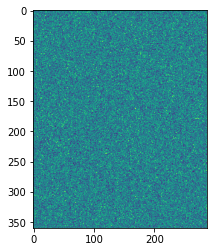

In [14]:
img = trn_ds[5]
plt.imshow(img[1].mean(0))
img[0].max()

In [15]:
class CustomLoss(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss_func = loss_func
    
    def forward(self, output, mask, label):
        return self.loss_func(output * (1 - mask), label * (1 - mask))
        
        
    

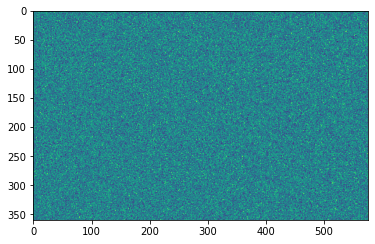

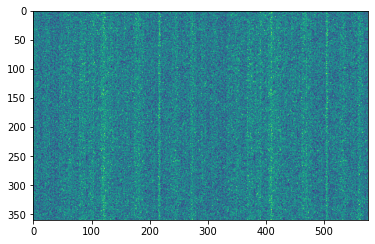

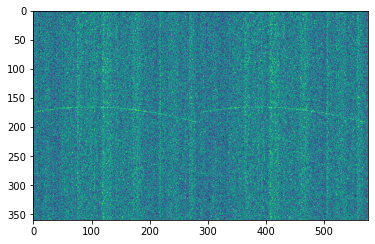

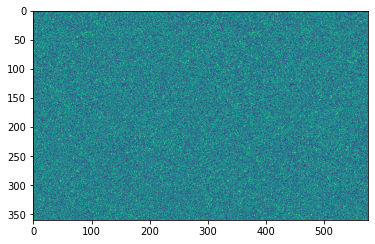

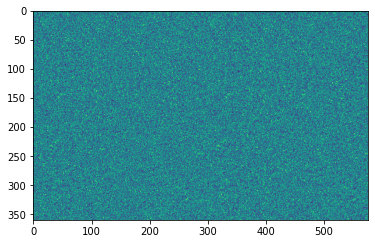

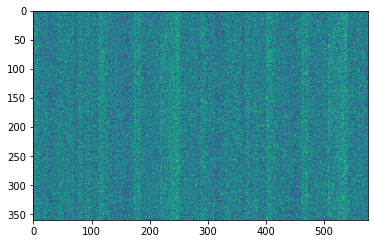

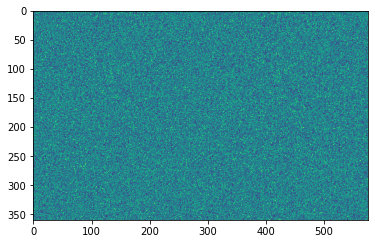

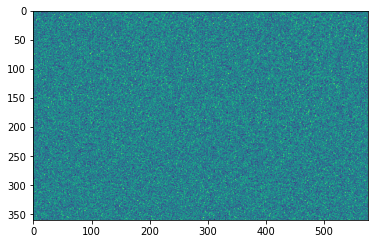

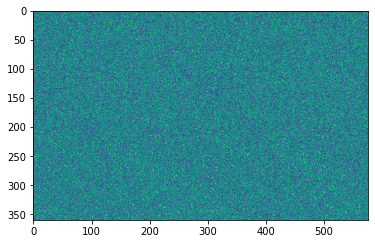

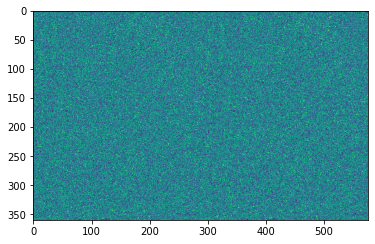

In [16]:



for i in range(10):
    img, y, _= trn_ds[np.random.randint(0, len(trn_ds))]
    customplot(torch.tensor(img), torch.tensor(y))
    plt.pause(0.1)
    #plt.figure(figsize=(8, 8))
    #plt.title('Spectrogram')
    #plt.xlabel('time')
    #plt.ylabel('frequency')
    #plt.imshow(img.mean(0))
    ##plt.imshow(np.concatenate([img[0], img[1]], 1))  # zooming in for dataset[10]
    #plt.colorbar()
    #plt.show()
    #print(y)
    #plt.pause(0.1)

   

In [17]:
trn_dl = DataLoader(
    trn_ds,
    batch_size=CFG.bs,
    shuffle=True,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=True,
)
vld_dl = DataLoader(
    vld_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
)
custom_model = SRMNet(in_chn=2)
custom_model.load_state_dict(torch.load('EXP_40_01_NV_TEST_V3/EXP_40_01_NV_TEST_V3_SRG_REAL_NOISE_TO_VOID_TEST_V3_DATA_V31_9.pth'))
opt = torch.optim.AdamW(custom_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
loss_func = CustomLoss(nn.L1Loss())
warmup_steps = int(len(trn_dl) * int(CFG.warmup_pct * CFG.epoch))
total_steps = int(len(trn_dl) * CFG.epoch)
sched = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

fit_mixup(
    epochs=CFG.epoch,
    model=custom_model,
    train_dl=trn_dl,
    valid_dl=vld_dl,
    loss_fn=loss_func,
    opt=opt,
    folder=CFG.folder,
    exp_name=f"{CFG.exp_name}",
    device="cuda:1",
    sched=sched,
)

epoch,train_loss,valid_loss
0,0.019293,0.019308
1,0.019292,0.019300
2,0.019290,0.019307
3,0.019290,0.019305
4,0.019291,0.019309
5,0.019289,0.019301
6,0.019288,0.019309
7,0.019289,0.019313
8,0.019290,0.019305
9,0.019287,0.019302


Better model found at epoch 0 with value: 0.019308409686067472.
Better model found at epoch 1 with value: 0.019299894607982985.
Better model found at epoch 2 with value: 0.019307012820426833.
Better model found at epoch 3 with value: 0.019305292240636335.
Better model found at epoch 4 with value: 0.01930882858681485.
Better model found at epoch 5 with value: 0.019301467851743286.
Better model found at epoch 6 with value: 0.01930948784217148.
Better model found at epoch 7 with value: 0.01931289623119819.
Better model found at epoch 8 with value: 0.019304664922866834.
Better model found at epoch 9 with value: 0.019301504664910474.
Training done


In [12]:
from tqdm import tqdm

In [32]:
import h5py
class DataV0Valid():
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.freq_tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        filename=r.id
        file_id = Path(r.id).stem
        img = np.empty((2, 360, 128), dtype=np.float32)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64
                p = a.real**2 + a.imag**2  # power
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
                img[ch] = normalize(p, clip=True)
        if self.freq_tfms:
            if np.random.rand() <= 0.5: # horizonta
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= 0.5: # vertical 
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= 0.5: # vertical 
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
        img = torch.tensor(img)  
        return img
    
import h5py
class DataV0:
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """

    def __init__(self, df, tfms=False):
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        #fid, img, H1, L1 = dataload(r.id)
        #img =  np.array(preprocess(1, img, H1, L1))
        
        img = np.array(torch.load(str(r.id).replace('.h5', '.pth')))
        
        img = img.reshape(2, 360, 288, 20).mean(-1)
        img = np.array(img)
        img[0] = normalize(img[0], clip=True)
        img[1] = normalize(img[1], clip=True)
        
        if self.tfms:
            if np.random.rand() <= 0.5:  # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= 0.5:  # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= 0.5:  # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
        fn = Path(r.id)
        
        return torch.tensor(img), str(fn).replace(fn.suffix, '_DENOISE_V5.pth')
    



In [33]:
custom_model =  SRMNet(in_chn=2)
custom_model.load_state_dict(torch.load('EXP_40_01_NV_TEST_V5/EXP_40_01_NV_TEST_V5_SRG_REAL_NOISE_TO_VOID_TEST_V5_DATA_V31_9.pth'))
custom_model.cuda();
custom_model.eval();

In [34]:
#submit = pd.read_csv('../data/SUBS/ENS_39.csv')
##submit = submit.set_index('id').drop(pos + maybe).reset_index()
#submit.columns = ['fn', 'target']
#submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test')/f'{x}.hdf5')
#submit.columns = ['id', 'target']

In [35]:
val = pd.read_csv('../data/SPLITS/V_20/val_df.csv')
trn = pd.read_csv('../data/SPLITS/V_20/trn_df.csv')
#submit = submit.set_index('id').drop(pos + maybe).reset_index()
submit = pd.read_csv('../data/sample_submission.csv')
#submit = submit.set_index('id').loc[pos].reset_index()
submit.columns = ['fn', 'target']
submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test/')/f'{x}.pth')
submit.columns = ['id', 'target']

In [53]:
trn_ds = DataV0(submit)
trn_dl = DataLoader(
    trn_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=False,
)

In [54]:
with torch.no_grad():
    for imgs, fns in tqdm(trn_dl):
        out = custom_model(imgs.cuda()).detach().cpu()
        out = torch.concat([imgs, out], -1)
        for img, fn in zip(out, fns):
            torch.save(img, fn)


100%|████████████████████████████████████████████████████████████████████████████████| 997/997 [08:45<00:00,  1.90it/s]


In [ ]:
ou